In [99]:
import pandas as pd
import numpy as np
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel,Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
movies = pd.read_json('data/1960_1980.json')
movies.head()

,summary,title
0,In 1699 Dr Lemuel Gulliver Kerwin Mathews is ...,The 3 Worlds of Gulliver
1,The Man Edmond OBrien is the accomplice of Ma...,The 3rd Voice
10,AbdullaMahipal is a smart and brave young man...,Abdulla (1960 film)
100,is a French film directed by Julien Duvivier ...,Boulevard (1960 film)
1000,A Greek military hero named Darios Rory Calho...,The Colossus of Rhodes (film)


In [97]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords.words('english')] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    words = list(df['summary'])
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[plot] for plot in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [100]:
m_corpus, m_id2word, bigram = get_corpus(movies)

In [35]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [38]:
doc_sample = movies[movies['title'] == 'Bombs on Monte Carlo (1960 film)'].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Monte', 'Carlo', 'German', 'Bomben', 'auf', 'Monte', 'Carlo', 'is', 'a', '1960', 'German', 'comedy', 'film', 'directed', 'by', 'Georg', 'Jacoby', 'and', 'starring', 'Eddie', 'Constantine', 'Marion', 'Michael', 'and', 'Gunther', 'Philipp', 'The', 'film', 'was', 'based', 'on', 'a', 'novel', 'by', 'Fritz', 'ReckMalleczewen', 'which', 'had', 'already', 'between', 'adapted', 'as', 'a', 'film', 'in', '1931', 'as', 'Bombs', 'on', 'Monte', 'Carlo', 'Location', 'shooting', 'took', 'place', 'in', 'Monaco', 'Nice', 'and', 'at', 'the', 'Schleissheim', 'Palace', 'in', 'Munich', 'The', 'films', 'sets', 'were', 'designed', 'by', 'the', 'art', 'directors', 'Ernst', 'H', 'Albrecht', 'and', 'Niko', 'Matul', '', '', '']


 tokenized and lemmatized document: 
['mont', 'carlo', 'german', 'bomben', 'mont', 'carlo', 'german', 'comedi', 'film', 'direct', 'georg', 'jacobi', 'star', 'eddi', 'constantin', 'marion', 'michael', 'gunther', 'philipp', 'film', 'base', 'novel', 'fritz', 'reckmall

In [39]:
processed_docs = movies['summary'].map(preprocess)


In [40]:
dictionary  = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    count += 1
    if count > 10:
        break

In [41]:
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [43]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [101]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=8,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Topic : 0 Word: 0.076*"film_directed" + 0.044*"film_stars" + 0.032*"lead_roles" + 0.029*"directed" + 0.025*"produced" + 0.023*"film_musical" + 0.020*"indian_malayalam" + 0.019*"film_festival" + 0.017*"starring" + 0.012*"film"
Topic : 1 Word: 0.012*"men" + 0.009*"killed" + 0.008*"gang" + 0.007*"kill" + 0.006*"town" + 0.006*"one" + 0.006*"two" + 0.006*"army" + 0.006*"kills" + 0.006*"group"
Topic : 2 Word: 0.006*"father" + 0.005*"wife" + 0.005*"life" + 0.005*"family" + 0.004*"one" + 0.004*"home" + 0.004*"man" + 0.004*"mother" + 0.004*"tells" + 0.004*"house"
Topic : 3 Word: 0.007*"john" + 0.007*"police" + 0.005*"car" + 0.005*"joe" + 0.004*"george" + 0.004*"paul" + 0.004*"money" + 0.003*"harry" + 0.003*"david" + 0.003*"new"
Topic : 4 Word: 0.057*"film" + 0.014*"directed" + 0.011*"film_directed" + 0.011*"starring" + 0.010*"films" + 0.008*"first" + 0.007*"movie" + 0.006*"released" + 0.006*"also" + 0.005*"italian"
Topic : 5 Word: 0.020*"maria" + 0.017*"raju" + 0.013*"italian" + 0.009*"marie" +

In [108]:
coherence_values = []
model_list = []
for num_topics in range(2,60,6):
    model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=num_topics,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, 
                                    texts=bigram,
                                    dictionary=m_id2word,
                                   coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

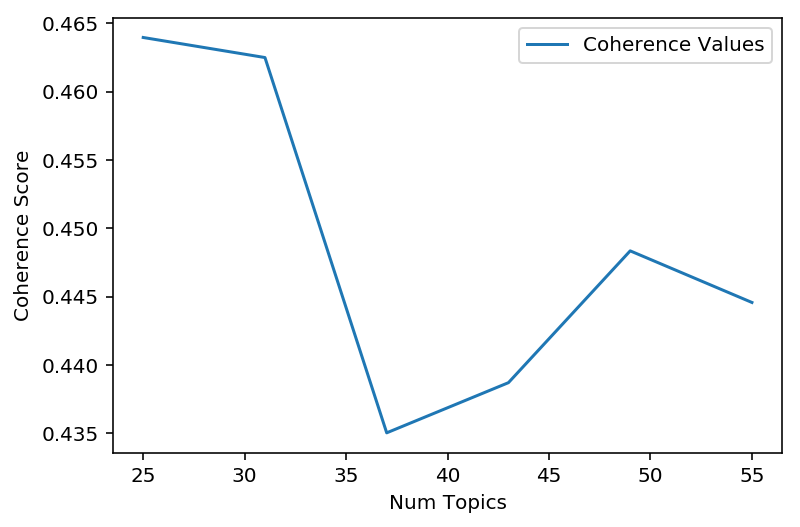

In [109]:

X = np.arange(2,60,6)

fig, ax = plt.subplots()
ax.plot(X, coherence_values, label="Coherence Values")
ax.set_xlabel('Num Topics')
ax.set_ylabel('Coherence Score')
plt.legend()
plt.show()

In [106]:
for m, cv in zip(X, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4265
Num Topics = 8  has Coherence Value of 0.4833
Num Topics = 14  has Coherence Value of 0.421
Num Topics = 20  has Coherence Value of 0.4513
Num Topics = 26  has Coherence Value of 0.4389
Num Topics = 32  has Coherence Value of 0.4396
Num Topics = 38  has Coherence Value of 0.443


In [69]:
train_vecs = []
for i in range(len(movies)):
    top_topics = lda_model.get_document_topics(corpus_tfidf[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(8)]
    train_vecs.append(topic_vec)

In [83]:
train_vecs[0]

[0.012516569,
 0.12139622,
 0.54146653,
 0.012518243,
 0.0125198215,
 0.088762626,
 0.012531708,
 0.1982883]

In [112]:
lda_model.show_topic(3)

[('john', 0.006990252),
 ('police', 0.006927536),
 ('car', 0.00545362),
 ('joe', 0.0047498927),
 ('george', 0.004031561),
 ('paul', 0.003674468),
 ('money', 0.0036290162),
 ('harry', 0.0034054923),
 ('david', 0.0033684478),
 ('new', 0.0027360858)]

In [96]:
lda_model[]

nltk.corpus.util.LazyCorpusLoader

### Word Embedding

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])